In [1]:
import argparse
import os
import pathlib
import sys
import numpy as np
import torch
import imageio
import bayes3d as b
from tqdm import tqdm
import jax.numpy as jnp
import pytorch3d.transforms as t3d
import nvdiffrast.torch as dr
import diffdope as dd
import pytorch3d.transforms
import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [2]:
b.setup_visualizer()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/


In [3]:
max_iter           = 10000
repeats            = 1
log_interval       = 10
display_interval   = None
display_res        = 512
lr_base            = 1e-3
lr_falloff         = 1.0
nr_base            = 1.0
nr_falloff         = 1e-4
grad_phase_start   = 0.5
resolution         = [200,200]
out_dir            = None
log_fn             = None
mp4save_interval   = None
mp4save_fn         = None
use_opengl         = False

In [4]:
glctx = dr.RasterizeGLContext() #if use_opengl else dr.RasterizeCudaContext()

In [1]:
model_dir = os.path.join(b.utils.get_assets_dir(),"bop/ycbv/models")
idx = 14
mesh_path = os.path.join(model_dir,"obj_" + "{}".format(idx).rjust(6, '0') + ".ply")
m = b.utils.load_mesh(mesh_path)
m = b.utils.scale_mesh(m, 1.0/100.0)

# m = b.utils.make_cuboid_mesh(jnp.array([0.5, 0.5, 0.2]))

vtx_pos = torch.from_numpy(m.vertices.astype(np.float32)).cuda()
pos_idx = torch.from_numpy(m.faces.astype(np.int32)).cuda()
col_idx = torch.from_numpy(np.zeros((vtx_pos.shape[0],3)).astype(np.int32)).cuda()
vtx_col = torch.from_numpy(np.ones((1,3)).astype(np.float32)).cuda()
# print("Mesh has %d triangles and %d vertices." % (pos_idx.shape[0], pos.shape[0]))
print(pos_idx.shape, vtx_pos.shape, col_idx.shape, vtx_col.shape)
print(vtx_pos, vtx_col)

NameError: name 'os' is not defined

In [6]:
def posevec_to_matrix(position, quat):
    return torch.cat(
        (
            torch.cat((pytorch3d.transforms.quaternion_to_matrix(quat), position.unsqueeze(1)), 1),
            torch.tensor([[0.0, 0.0, 0.0, 1.0]],device=device),
        ),
        0,
    )

In [7]:
intrinsics = b.Intrinsics(
    height=200,
    width=200,
    fx=200.0, fy=200.0,
    cx=100.0, cy=100.0,
    near=0.01, far=5.5
)

mvp = torch.tensor(np.array(b.camera._open_gl_projection_matrix(
    intrinsics.height, intrinsics.width, 
    intrinsics.fx, intrinsics.fy, 
    intrinsics.cx, intrinsics.cy, 
    intrinsics.near, intrinsics.far
)), device=device)
mvp

tensor([[ 2.0000,  0.0000,  0.0050,  0.0000],
        [ 0.0000,  2.0000,  0.0050,  0.0000],
        [ 0.0000,  0.0000,  0.9964, -0.0200],
        [ 0.0000,  0.0000,  1.0000,  0.0000]], device='cuda:0')

In [8]:
def render(pos, quat):
    mtx = posevec_to_matrix(pos, quat)
    proj_cam = mvp
    pos = vtx_pos[None,...]
    posw = torch.cat([pos, torch.ones([pos.shape[0], pos.shape[1], 1]).cuda()], axis=2)

    final_mtx_proj = torch.matmul(proj_cam, mtx)
    pos_clip_ja = dd.xfm_points(pos.contiguous(), final_mtx_proj[None,...])
    # pos_clip_ja    = torch.matmul(posw, torch.transpose(torch.matmul(proj_cam, mtx),1,0))
    rast_out, rast_out_db = dr.rasterize(glctx, pos_clip_ja, pos_idx, resolution=resolution)

    gb_pos, _ = dr.interpolate(posw, rast_out, pos_idx, rast_db=rast_out_db)
    mask= rast_out[...,2] > 0
    shape_keep = gb_pos.shape
    gb_pos = gb_pos.reshape(shape_keep[0], -1, shape_keep[-1])
    gb_pos = gb_pos[..., :3]

    depth = dd.xfm_points(gb_pos.contiguous(), mtx[None,...])
    depth = depth.reshape(shape_keep)[..., 2]
    return depth, mask

/var/tmp/ipykernel_250866/796895343.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  quat = torch.tensor(torch.rand(4,device=device) - 0.5,device=device)


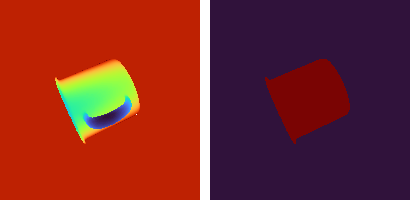

In [52]:
pos = torch.tensor([0.0, 0.0, 2.5],device=device)
quat = torch.tensor(torch.rand(4,device=device) - 0.5,device=device)
obs_depth, mask = render(pos, quat)
viz_gt = b.get_depth_image(jnp.array(obs_depth[0].cpu().numpy()))
mask_gt = b.get_depth_image(jnp.array(mask[0].cpu().numpy()) * 1.0,max=1.1)
# print(depth[...,None])
b.viz.hstack_images([viz_gt,mask_gt])

/var/tmp/ipykernel_250866/3613549959.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  quat =  torch.tensor(torch.rand(4,device=device) - 0.5,device=device, requires_grad=True)


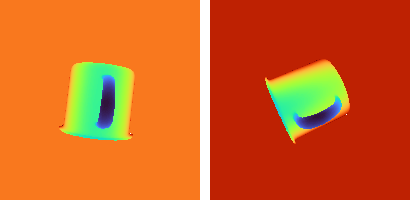

In [53]:
pos = torch.tensor([0.0, 0.0,2.4],device=device, requires_grad=True)
quat =  torch.tensor(torch.rand(4,device=device) - 0.5,device=device, requires_grad=True)
rendered_image,_ = render(pos,quat)
viz =  b.get_depth_image(jnp.array(rendered_image[0].detach().cpu().numpy()))
b.hstack_images([viz, viz_gt])

tensor([-0.1147, -0.0545,  0.6152, -0.0764], device='cuda:0',
       requires_grad=True)


0.021300427615642548: 100%|██████████| 300/300 [00:01<00:00, 197.28it/s]


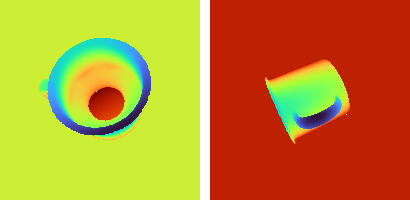

In [60]:
optimizer = torch.optim.SGD([
    {'params': [pos], 'lr': 0.01, "name": "pos"},
    {'params': [quat], 'lr': 1.0, "name": "quat"},
], lr=0.0)
print(quat)

pbar = tqdm(range(300))
for _ in pbar:
    rendered_image,mask2 = render(pos,quat)
    loss = torch.abs((obs_depth - rendered_image) * mask).mean()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    pbar.set_description(f"{loss.item()}")
viz =  b.get_depth_image(jnp.array(rendered_image[0].detach().cpu().numpy()))
b.hstack_images([viz, viz_gt])

In [26]:
b.clear()
depth_np = jnp.array(depth[0].detach().cpu().numpy())
cloud = b.unproject_depth_jit(depth_np, intrinsics).reshape(-1,3)
b.show_cloud("1",cloud)

b.show_trimesh("m", m)
b.set_pose("m", jnp.array(mtx.cpu().numpy()))

In [18]:
cloud.max(0)

Array([1.2375   , 1.2375   , 3.0237753], dtype=float32)

In [116]:
pose =  jnp.array(mtx.cpu().numpy())
pose

Array([[-0.45291662,  0.41978574,  0.78654087,  0.        ],
       [-0.4266136 ,  0.6726148 , -0.60464054,  0.        ],
       [-0.78285843, -0.60940075, -0.12555218,  2.5       ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]],      dtype=float32)

In [5]:
import bayes3d as b
import os
import jax.numpy as jnp
intrinsics = b.Intrinsics(
    height=200,
    width=200,
    fx=200.0, fy=200.0,
    cx=100.0, cy=100.0,
    near=0.01, far=5.5
)
b.setup_renderer(intrinsics)
model_dir = os.path.join(b.utils.get_assets_dir(),"bop/ycbv/models")
idx = 14
mesh_path = os.path.join(model_dir,"obj_" + "{}".format(idx).rjust(6, '0') + ".ply")
b.RENDERER.add_mesh_from_file(mesh_path, scaling_factor=1.0/1000.0)

[E rasterize_gl.cpp:121] OpenGL version reported as 4.6


Increasing frame buffer size to (width, height, depth) = (224, 224, 1024)


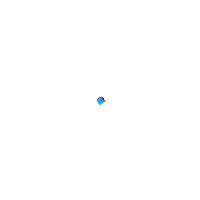

In [8]:
pose = jnp.array(
    [[-0.45291662,  0.41978574,  0.78654087,  0.        ],
       [-0.4266136 ,  0.6726148 , -0.60464054,  0.        ],
       [-0.78285843, -0.60940075, -0.12555218,  2.5       ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]]
)
img = b.RENDERER.render(pose[None,...], jnp.array([0]))
b.get_depth_image(img[...,2])

In [106]:
b.setup_visualizer()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7002/static/


In [108]:
from bayes3d.viz.open3dviz import Open3DVisualizer
visualizer = Open3DVisualizer(intrinsics)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
[Open3D INFO] EGL headless mode enabled.
FEngine (64 bits) created at 0x55f5230b5c40 (threading is enabled)
EGL(1.5)
OpenGL(4.1)


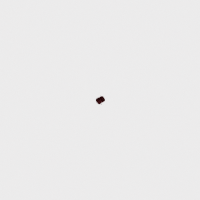

In [109]:
visualizer.make_mesh_from_file(mesh_path, jnp.array(mtx.cpu().numpy()), scaling_factor=1.0/1000.0)
rgbd = visualizer.capture_image(intrinsics, jnp.eye(4))
b.get_rgb_image(rgbd.rgb)

In [103]:
b.setup_renderer(intrinsics)
b.RENDERER.add_mesh_from_file(mesh_path, scaling_factor=1.0/1000.0)

ImportError: generic_type: type "RasterizeGLStateWrapper" is already registered!

In [ ]:
b.RENDERER.render()

In [93]:
depth_np.shape

(100, 100)

In [70]:
depth[...,None]

tensor([[[[-2.5000],
          [-2.5000],
          [-2.5000],
          ...,
          [-2.5000],
          [-2.5000],
          [-2.5000]],

         [[-2.5000],
          [-2.5000],
          [-2.5000],
          ...,
          [-2.5000],
          [-2.5000],
          [-2.5000]],

         [[-2.5000],
          [-2.5000],
          [-2.5000],
          ...,
          [-2.5000],
          [-2.5000],
          [-2.5000]],

         ...,

         [[-2.5000],
          [-2.5000],
          [-2.5000],
          ...,
          [-2.5000],
          [-2.5000],
          [-2.5000]],

         [[-2.5000],
          [-2.5000],
          [-2.5000],
          ...,
          [-2.5000],
          [-2.5000],
          [-2.5000]],

         [[-2.5000],
          [-2.5000],
          [-2.5000],
          ...,
          [-2.5000],
          [-2.5000],
          [-2.5000]]]], device='cuda:0')

In [94]:
depth.shape

torch.Size([1, 100, 100])

In [78]:
pos = torch.tensor([0.0, 0.0, -5.5],device=device)
quat =  torch.tensor(torch.rand(4,device=device) - 0.5,device=device)
mtx = dd.matrix_batch_44_from_position_quat(quat[None,...],pos[None,...])
camera = dd.Camera(
    fx=100.0,
    fy=100.0,
    cx=50.0,
    cy=50.0,
    im_width=100,
    im_height=100,
)
camera.cuda()
proj_cam = camera.cam_proj[None,...]
pos = vtx_pos[None,...]

posw = torch.cat([pos, torch.ones([pos.shape[0], pos.shape[1], 1]).cuda()], axis=2)

final_mtx_proj = torch.matmul(proj_cam, mtx)
pos_clip_ja = dd.xfm_points(pos.contiguous(), final_mtx_proj)

rast_out, rast_out_db = dr.rasterize(
    glctx, pos_clip_ja, pos_idx, resolution=resolution
)

gb_pos, _ = dr.interpolate(posw, rast_out, pos_idx, rast_db=rast_out_db)
shape_keep = gb_pos.shape
gb_pos = gb_pos.reshape(shape_keep[0], -1, shape_keep[-1])
gb_pos = gb_pos[..., :3]

depth = dd.xfm_points(gb_pos.contiguous(), mtx)
depth = depth.reshape(shape_keep)[..., 2] * -1

fig = plt.figure()
plt.imshow(depth[0].detach().cpu().numpy())
plt.colorbar()
fig.savefig("test.png")

/var/tmp/ipykernel_219138/3100620235.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  quat =  torch.tensor(torch.rand(4,device=device) - 0.5,device=device)


TypeError: 'int' object is not iterable

In [ ]:

ground_truth_image = render_wrapper(pos,quat)
viz_gt = get_viz(ground_truth_image)
viz_gt


In [ ]:
def quaternion_to_matrix(poses: torch.Tensor) -> torch.Tensor:
    """
    Convert rotations given as quaternions to rotation matrices.

    Args:
        quaternions: quaternions with real part first,
            as tensor of shape (..., 4).

    Returns:
        Rotation matrices as tensor of shape (..., 3, 3).
    """
    positions = poses[...,:3]
    quaternions = poses[...,3:]
    r, i, j, k = torch.unbind(quaternions, -1)
    x, y, z = torch.unbind(positions, -1)
    # pyre-fixme[58]: `/` is not supported for operand types `float` and `Tensor`.
    two_s = 2.0 / (quaternions * quaternions).sum(-1)

    o = torch.stack(
        (
            1 - two_s * (j * j + k * k),
            two_s * (i * j - k * r),
            two_s * (i * k + j * r),
            x,
            two_s * (i * j + k * r),
            1 - two_s * (i * i + k * k),
            two_s * (j * k - i * r),
            y,
            two_s * (i * k - j * r),
            two_s * (j * k + i * r),
            1 - two_s * (i * i + j * j),
            z,
            0.0 * x,
            0.0 * x,
            0.0 * x,
            0.0 * x + 1.0,
        ),
        -1,
    )
    rotation_matrices = o.reshape(quaternions.shape[:-1] + (4, 4))
    return rotation_matrices

# Transform vertex positions to clip space
def transform_pos(mtx, pos):
    t_mtx = torch.from_numpy(mtx).cuda() if isinstance(mtx, np.ndarray) else mtx
    # (x,y,z) -> (x,y,z,1)
    posw = torch.cat([pos, torch.ones([pos.shape[0], 1]).cuda()], axis=1)
    return torch.matmul(posw, t_mtx.t())[None, ...]

def render(glctx, mtx, pos, pos_idx, resolution: int):
    # Setup TF graph for reference.
    depth_ = pos[..., 2:3]
    depth = torch.tensor([[[(z_val/1)] for z_val in depth_.squeeze()]], dtype=torch.float32).cuda()
    pos_clip    = transform_pos(mtx, pos)
    rast_out, _ = dr.rasterize(glctx, pos_clip, pos_idx, resolution=[resolution, resolution])
    color   , _ = dr.interpolate(depth, rast_out, pos_idx)
    # color       = dr.antialias(color, rast_out, pos_clip, pos_idx)
    return color
    # return rast_out[:,:,:,2:3]


In [ ]:
datadir = "/home/nishadgothoskar/bayes3d/nvdiffrast/samples/data"
with np.load(f'{datadir}/cube_p.npz') as f:
    pos_idx, pos, col_idx, col = f.values()
print("Mesh has %d triangles and %d vertices." % (pos_idx.shape[0], pos.shape[0]))

# Some input geometry contains vertex positions in (N, 4) (with v[:,3]==1).  Drop
# the last column in that case.
if pos.shape[1] == 4: pos = pos[:, 0:3]

# Create position/triangle index tensors
pos_idx = torch.from_numpy(pos_idx.astype(np.int32)).cuda()
vtx_pos = torch.from_numpy(pos.astype(np.float32)).cuda()
print(pos_idx.shape, vtx_pos.shape)

# model_dir = os.path.join(b.utils.get_assets_dir(),"bop/ycbv/models")
# idx = 14
# mesh_path = os.path.join(model_dir,"obj_" + "{}".format(idx).rjust(6, '0') + ".ply")
# m = b.utils.load_mesh(mesh_path)
# m = b.utils.scale_mesh(m, 1.0/100.0)

# vtx_pos = torch.from_numpy(m.vertices.astype(np.float32)).cuda()
# pos_idx = torch.from_numpy(m.faces.astype(np.int32)).cuda()
# col_idx = torch.from_numpy(np.zeros((vtx_pos.shape[0],3)).astype(np.int32)).cuda()
# vtx_col = torch.from_numpy(np.ones((1,3)).astype(np.float32)).cuda()

In [ ]:
pose_target = torch.tensor([0.0, 0.0, -5.0, 1.0, 1.2, 0.4, 1.0]).cuda()
rast_target = render(glctx, torch.matmul(mvp, quaternion_to_matrix(pose_target)), vtx_pos, pos_idx,  resolution)
img_target  = rast_target[0].detach().cpu().numpy()
b.hstack_images([
    b.get_depth_image(img_target[:,:,0]* 255.0) ,
])


In [ ]:
pose_opt = torch.tensor([0.0, 0.0, -6.0, 1.0, 1.2, 0.4, 1.0],dtype=torch.float32, device='cuda', requires_grad=True)
loss_best   = np.inf

rast_opt = render(glctx, torch.matmul(mvp, quaternion_to_matrix(pose_opt)), vtx_pos, pos_idx,  resolution)
img_opt  = rast_opt[0].detach().cpu().numpy()
b.hstack_images([
    b.get_depth_image(img_opt[:,:,0]* 255.0) ,
    b.get_depth_image(img_target[:,:,0]* 255.0) ,
])


In [ ]:
diff = (rast_opt - rast_target)**2 # L2 norm.
diff.sum()

In [ ]:
optimizer = torch.optim.Adam([pose_opt],  lr=0.00001)
images = []

for _ in tqdm(range(200)):    
    rast_opt = render(glctx, torch.matmul(mvp, quaternion_to_matrix(pose_opt)), vtx_pos, pos_idx,  resolution)

    diff = (rast_opt - rast_target)**2 # L2 norm.
    loss = torch.mean(diff)
    loss_val = float(loss)
    
    if (loss_val < loss_best) and (loss_val > 0.0):
        loss_best = loss_val
                
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print(loss)    
    with torch.no_grad():
        pose_opt /= torch.sum(pose_opt**2)**0.5
    
    img_opt  = rast_opt[0].detach().cpu().numpy()
    images.append(
        b.hstack_images([
            b.get_depth_image(img_opt[:,:,0]* 255.0) ,
            b.get_depth_image(img_target[:,:,0]* 255.0) ,
        ])
    )

In [ ]:
b.vstack_images([images[0],images[-1]])